In [612]:
import numpy as np
from scipy.constants import Boltzmann as k
from numpy.typing import NDArray
from typing import List
import matplotlib.pyplot as plt
from numba import jit
import numba as nb
from scipy.ndimage import convolve, generate_binary_structure

In [651]:
N = 3
@nb.njit(parallel=True)
def generate_lattice(L: int, p: float = 0.5) -> np.ndarray:
    init_lattice = np.empty((L, L), dtype=np.float32)
    for i in nb.prange(L):
        for j in range(L):
            # Generate a random number for each element
            random_value = np.random.random()
            if random_value >= p:
                init_lattice[i, j] = 1
            else:
                init_lattice[i, j] = -1
    return init_lattice

state = generate_lattice(10, 0.5)

In [652]:
print(state)

[[ 1. -1. -1. -1.  1.  1. -1. -1. -1.  1.]
 [-1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]
 [-1. -1.  1. -1.  1.  1. -1.  1. -1.  1.]
 [-1. -1. -1. -1. -1.  1.  1.  1.  1. -1.]
 [ 1. -1. -1.  1.  1.  1. -1. -1. -1. -1.]
 [-1.  1.  1. -1. -1. -1. -1. -1. -1.  1.]
 [ 1. -1. -1. -1. -1.  1. -1. -1.  1. -1.]
 [-1. -1. -1. -1.  1.  1. -1. -1. -1.  1.]
 [ 1. -1. -1.  1. -1. -1.  1. -1.  1. -1.]
 [ 1. -1.  1.  1.  1.  1.  1.  1.  1.  1.]]


In [947]:
def energy_naive(lattice: np.ndarray) -> int:
    H = 0
    for row in lattice:
        H += (np.sum(row[:-1] * row[1:]) + row[0]*row[-1])
    
    for col in lattice.T:
        H += (np.sum(col[:-1] * col[1:]) + col[0]*col[-1])

    return -H


In [948]:
def energy_conv(lattice: np.ndarray) -> int:
    kern = generate_binary_structure(2,1)
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode = "wrap")
    return arr.sum()/2

In [949]:
import numpy as np
from numba import jit

@jit(nopython=True)  # Use the nopython mode for better performance
def energy_numba(lattice: np.ndarray) -> int:
    H = 0
    N = lattice.shape[0]
    M = lattice.shape[1]

    # Calculate horizontal interactions with periodic boundary conditions
    for i in range(N):
        for j in range(M):
            right_neighbor = (j + 1) % M  # Wrap around horizontally
            H += lattice[i, j] * lattice[i, right_neighbor]

    # Calculate vertical interactions with periodic boundary conditions
    for i in range(N):
        for j in range(M):
            down_neighbor = (i + 1) % N  # Wrap around vertically
            H += lattice[i, j] * lattice[down_neighbor, j]

    return -H

In [951]:
import numba as nb
@jit(parallel=True)
def energy(lattice):
    N, M = lattice.shape  # Assuming a square lattice for simplicity
    H = 0.0
    
    # Loop over all elements to calculate horizontal and vertical interactions
    # Parallelize the outer loop
    for i in nb.prange(N):
        for j in range(M):
            right_neighbor = (j + 1) % M
            down_neighbor = (i + 1) % N
            
            # Periodic boundary conditions are handled by wrapping index
            H += lattice[i, j] * (lattice[i, right_neighbor] + lattice[down_neighbor, j])
    
    return -H

In [657]:
print(energy(state))

-0.0


In [658]:
print(energy_numba(state))

-0.0


In [659]:
print(energy_naive(state))

-0.0


In [660]:
print(energy_conv(state))

0.0


In [694]:
def plot_lattice(lattice):
    plt.imshow(lattice, cmap = plt.cm.colors.ListedColormap(['#0000FF', '#FF0000']))

In [1060]:
@jit(nopython=True)
def delta_energy(initial_lattice: np.ndarray, spin_to_flip: tuple[int, int]) -> int:
    #Calculates E_new - E_old
    L = initial_lattice.shape[0]
    sum_of_neighbors = 0
    x,y = spin_to_flip[0], spin_to_flip[1]

    sum_of_neighbors = (initial_lattice[(x + 1)%L, y] +
                        initial_lattice[(x - 1)%L, y] +
                        initial_lattice[x, (y + 1)%L] +
                        initial_lattice[x, (y - 1)%L])
     
    return 2 * sum_of_neighbors * initial_lattice[x, y]


In [1061]:
@jit(nopython=True)
def flip_spin_in_lattice(lattice: np.ndarray, spin: tuple[int,int]) -> np.ndarray:
    #given a lattice l, return a new lattice l'
    new_lattice = lattice.copy()
    new_lattice[spin] *= -1
    return new_lattice

In [1062]:
@jit(nopython=True)
def flip_random_spin(lattice: np.ndarray) -> tuple[int, int]:
    L = lattice.shape[0]
    x, y = np.random.randint(0, L), np.random.randint(0, L)
    return (x,y)

In [1063]:
cand_spin = flip_random_spin(state)
print(delta_energy(state, cand_spin), energy(flip_spin_in_lattice(state, cand_spin)) - energy(state))

-4.0 -4.0


In [1064]:
def magnetization(lattice: np.ndarray) -> float:
    return np.sum(lattice)

In [1065]:
@jit(nopython=True)
def sampler(type: str,init_dist: np.ndarray, beta: float, num_iters: int, sweep_size: int = 50):
    fixed_time_samples = []
    updated_samples = []
    sample = init_dist.copy()
    for i in range(num_iters):
        candidate_spin = flip_random_spin(sample)
        if type == "mh":
            acceptance_prop = min(1, np.exp(-beta * delta_energy(sample, candidate_spin)))
        elif type == "gibbs":
            acceptance_prop = 1/(1 + 1/np.exp(-beta * delta_energy(sample, candidate_spin)))
        else:
            print("error, sampler type must either be mh or gibbs")
            break
        if (acceptance_prop > np.random.random()):  
            sample = flip_spin_in_lattice(sample, candidate_spin)
            updated_samples.append(sample)
        if i % sweep_size == 0:
            fixed_time_samples.append(sample)
    return fixed_time_samples, updated_samples
            

In [1164]:
N, p, beta = 50, 0.5, 0.44

In [1165]:
mh_fixed_time_res, mh_updated_res = sampler('mh', generate_lattice(N, p), beta, 2_000_000)
print(len(mh_fixed_time_res), len(mh_updated_res))

40000 445561


In [1166]:
gibbs_fixed_time_res, gibbs_updated_res = sampler('gibbs', generate_lattice(N, p), beta, 2_000_000)
print(len(gibbs_fixed_time_res), len(gibbs_updated_res))


40000 322067


In [1167]:
def plot_magnetization_squared(samples: list):
    samples = np.array(samples)
    magnetization_squared_of_samples = (np.mean(samples, axis = (1,2)) ** 2)
    plt.plot(magnetization_squared_of_samples)
    plt.title("Magnetization density squared")

In [1168]:
def plot_magnetization(samples: list):
    samples = np.array(samples)
    magnetization_of_samples = (np.mean(samples, axis = (1,2)))
    plt.plot(magnetization_of_samples)
    plt.title("Magnetization density")

In [1169]:
def plot_energy(samples: list):
    L = samples[0].shape[0]
    energy_of_samples = [energy(sample)/(L**2) for sample in samples]
    plt.plot(energy_of_samples)
    plt.title("Energy density")

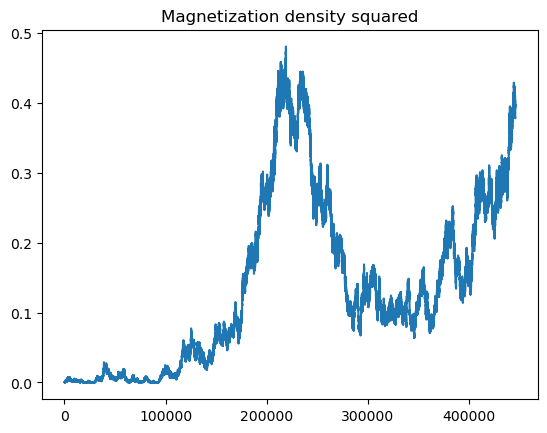

In [1170]:
plot_magnetization_squared(mh_updated_res)

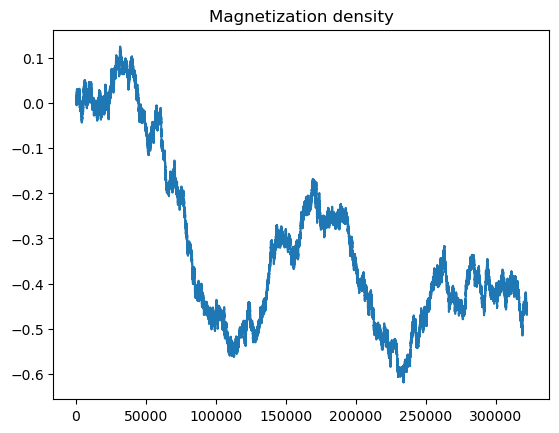

In [1171]:
plot_magnetization(gibbs_updated_res)

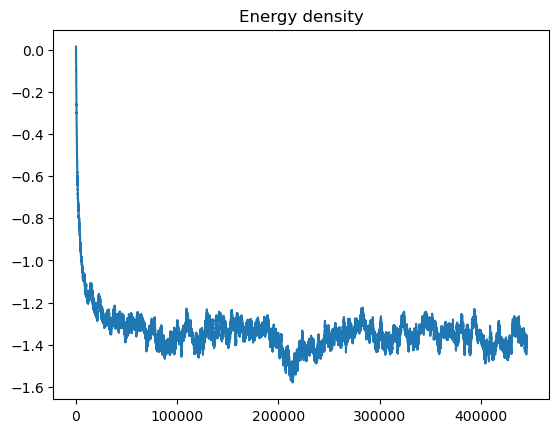

In [1172]:
plot_energy(mh_updated_res)

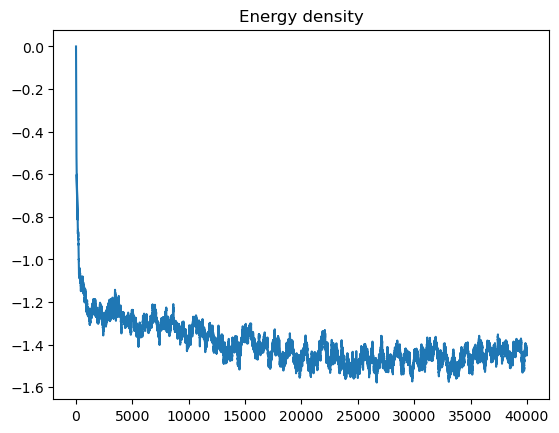

In [1144]:
plot_energy(gibbs_fixed_time_res)

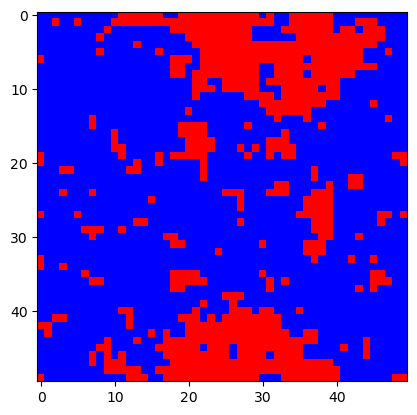

In [1175]:
plot_lattice(gibbs_updated_res[-1])